## 1. Data reading & first glance

**Challenge overview**

You were tasked with creating a model that predicts the price of a house based on its characteristics. 

The project will be divided into two major phases:
* Create a model to predict whether a house is expensive or not. 
* Create a model to predict the exact price of a house.


In [769]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


# reading
data =df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/housing-classification-iter6.csv") #reading data from csv
data.shape


(1460, 81)

The target column (what we want our model to predict) is usually denoted as y. We will "pop" it out from the rest of the data:


In [770]:
# X and y creation
X = data
y = X.pop("Expensive")


## 2. Train-test split

Before performing a deeper exploration, we will split the dataset into 2 chunks: train and test. We will use the train set to find patterns in the data and create a model. The test set will remain untouched, unseen, unexplored. It will be the "reality check" for our model, it will let us know whether our model is able to generalize. 

Here, we're using the function `train_test_split` to shuffle the observations randomly and create the train and test sets for both the `X` and the `y` objects at the same time, ensuring that they are shuffled the same way:


In [771]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123000)

## 3. Categorical encoding - "Automated" approach (Using Pipelines)

In the manual approach, to encode the categorical columns numericall, we have:

1. Selected the categorical columns.
2. Fitted a `OneHotEncoder` to them.
3. Transformed the categorical columns with the encoder.
4. Converted the sparse matrix into a dataframe.
5. Recovered the names of the columns.
6. Concatenated the one-hot columns with the numerical columns.

All these steps can be synthetised by using Scikit-Learn Pipelines and specifically something called `ColumnTransformer`, which allows us to apply different transformations to two or more groups of columns: in our case, categorical and numerical columns.

This process is also called creating "branches" in the pipeline. One branch for the categorical columns and another for the numerical columns. Each branch will contain as many transformers as we want. Then, the branches will meet again, and the transformed columns will be automatically concatenated. Let's see the process in action:

### 3.1. Creating the "numeric pipe" and the "categoric pipe"

In [772]:
# select categorical and numerical column names
X_cat_columns = X.select_dtypes(exclude="number").copy().columns
X_num_columns = X.select_dtypes(include="number").copy().columns

# create numerical pipeline, only with the SimpleImputer(strategy="mean")
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="median"))
 
 # create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"), # strategy="constant", fill_value="N_A"
    OneHotEncoder(handle_unknown = 'ignore')
)

In [773]:
# display pipeline
from sklearn import set_config
set_config(display = 'diagram')

### 3.2. Using `ColumnTransformer` a pipeline with 2 branches (the `preprocessor`) 

We simply tell the pipeline the following:

- One branch, called `"num_pipe"`, will apply the steps in the `numeric_pipe` to the columns named in `X_num_columns`
- The second branch, called `"cat_pipe"`, will apply the steps in the `categoric_pipe` to the columns named in `X_cat_columns`

In [774]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num_columns),
        ("cat_pipe", categoric_pipe, X_cat_columns)
        #("scale", StandardScalar())
      
    ]
)
preprocessor

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtU...
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtFinType2',
       'HeatingQC', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))])

### 3.3. Creating the `full_pipeline` (`preprocessor` + Decision Tree)

Pipelines are modular. The `preprocessor` we created above with the `ColumnTransformer` can become now a step in a new pipeline, that we'll call `full_piepline` and will include, as a last step, a Decision Tree model:

In [775]:
full_pipeline = make_pipeline(preprocessor, 
                              DecisionTreeClassifier())

full_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrA...
       'Neighborhood', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtFinType2',
       'HeatingQC', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [776]:
full_pipeline_test = make_pipeline(preprocessor, 
                              DecisionTreeClassifier())

full_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrA...
       'Neighborhood', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtFinType2',
       'HeatingQC', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

We can then fit this `full_pipeline` to the data:

Note: notice that we did not fit the `preprocessor` before —we only fit the pipeline once it has been full assembled.

In [777]:
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrA...
       'Neighborhood', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtFinType2',
       'HeatingQC', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [778]:
full_pipeline.predict(X_train)

array([0, 1, 0, ..., 0, 0, 0])

This full pipeline can make predictions, as any othet pipeline that ends with a model:

We are basically asking to combine what you have learned in this notebook (categorical encoding & branches) with what you learned in the previous one (using GridSearchCV for a whole Pipeline).


In [779]:

from sklearn.model_selection import GridSearchCV

full_pipeline = make_pipeline(preprocessor, 
                              DecisionTreeClassifier())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "decisiontreeclassifier__max_depth": range(2, 30, 2),
    "decisiontreeclassifier__min_samples_leaf": range(3, 20, 2),
    "decisiontreeclassifier__criterion":["gini","entropy"]
}

search = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=10,
                      verbose=1)

search.fit(X_train, y_train)

Fitting 10 folds for each of 504 candidates, totalling 5040 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearB...
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'columntransformer__num_pipe__simpleimputer__strategy': ['mean',
                                                                                  'median'],
                         'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': range(2, 30, 2),
                         'decisiontreeclassifier__min_samples_leaf': range(3, 20, 2)},
             verbose=1)

In [780]:
search.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 20,
 'decisiontreeclassifier__min_samples_leaf': 13}

In [781]:
# cross validation average accuracy
search.best_score_

0.9298334806955497

In [782]:
# training accuracy
y_train_pred = search.predict(X_train)

train_accuracy= accuracy_score(y_train, y_train_pred)

round(train_accuracy, 2)

0.95

In [783]:
# testing accuracy
y_test_pred = search.predict(X_test)

test_accuracy= accuracy_score(y_test, y_test_pred)

round(test_accuracy, 2)

0.95

### confusion matrix


In [784]:
from sklearn.metrics import confusion_matrix

confusion_matrix= confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None, normalize=None)
confusion_matrix

array([[239,   6],
       [ 10,  37]])

In [785]:
from sklearn.metrics import classification_report

classification_report(y_test, y_test_pred,labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')

'              precision    recall  f1-score   support\n\n           0       0.96      0.98      0.97       245\n           1       0.86      0.79      0.82        47\n\n    accuracy                           0.95       292\n   macro avg       0.91      0.88      0.89       292\nweighted avg       0.94      0.95      0.94       292\n'

In [786]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       245
           1       0.86      0.79      0.82        47

    accuracy                           0.95       292
   macro avg       0.91      0.88      0.89       292
weighted avg       0.94      0.95      0.94       292



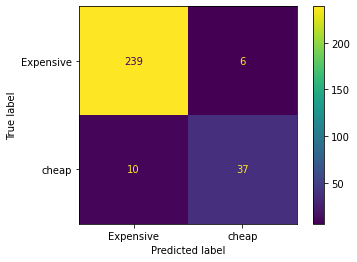

In [787]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

display= ConfusionMatrixDisplay(confusion_matrix,display_labels=['Expensive','cheap'])
display.plot()
plt.show()

For Test

In [788]:
data1 =df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv") #reading data from csv
data1.shape

(1459, 80)

In [789]:
testtest= search.predict(data1)

In [790]:
data1["Expensive"] = testtest

In [791]:
data1["Expensive"]

0       0
1       0
2       0
3       0
4       0
       ..
1454    0
1455    0
1456    0
1457    0
1458    0
Name: Expensive, Length: 1459, dtype: int64

In [792]:
Submission = data1[["Id", "Expensive"]]

In [793]:
Submission.to_csv("Hangman.csv", index = False)

In [794]:
from google.colab import files
files.download("Hangman.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>